# Download the German model for Stanza

Downloading the German model, which includes pre-trained models and resources necessary for tokenization and sentiment analysis in German language.

In [ ]:
import stanza import pandas as pd

In [2]:
#download models models for tokenization and sentiment analysis in the german language
stanza.download('de', processors='tokenize,sentiment')

#Initialize the pipeline for German language with tokenization and sentiment analysis
nlp = stanza.Pipeline(lang='de', processors='tokenize,sentiment')

2024-05-06 18:03:09 INFO: Downloaded file to /Users/ullasattler/stanza_resources/resources.json
2024-05-06 18:03:09 WARNING: Language de package default expects mwt, which has been added
2024-05-06 18:03:09 INFO: Downloading these customized packages for language: de (German)...
| Processor       | Package      |
----------------------------------
| tokenize        | gsd          |
| mwt             | gsd          |
| sentiment       | sb10k_charlm |
| forward_charlm  | newswiki     |
| pretrain        | conll17      |
| backward_charlm | newswiki     |

2024-05-06 18:03:09 INFO: File exists: /Users/ullasattler/stanza_resources/de/tokenize/gsd.pt
2024-05-06 18:03:09 INFO: File exists: /Users/ullasattler/stanza_resources/de/mwt/gsd.pt
2024-05-06 18:03:09 INFO: File exists: /Users/ullasattler/stanza_resources/de/sentiment/sb10k_charlm.pt
2024-05-06 18:03:10 INFO: File exists: /Users/ullasattler/stanza_resources/de/forward_charlm/newswiki.pt
2024-05-06 18:03:10 INFO: File exists: /Users/u

2024-05-06 18:03:10 INFO: Downloaded file to /Users/ullasattler/stanza_resources/resources.json
2024-05-06 18:03:10 WARNING: Language de package default expects mwt, which has been added
2024-05-06 18:03:10 INFO: Loading these models for language: de (German):
| Processor | Package      |
----------------------------
| tokenize  | gsd          |
| mwt       | gsd          |
| sentiment | sb10k_charlm |

2024-05-06 18:03:10 INFO: Using device: cpu
2024-05-06 18:03:10 INFO: Loading: tokenize
2024-05-06 18:03:11 INFO: Loading: mwt
2024-05-06 18:03:11 INFO: Loading: sentiment
2024-05-06 18:03:11 INFO: Done loading processors!


# Import Data

In [13]:
#Read csv 
#nrows just for now for testing-delete later
data = pd.read_csv('../data/subset_studium.csv', sep=';', nrows=700)

In [17]:
#Only use labeled data or rows that are not empty
data = data[data['Studium_Label'].notnull()]

In [38]:
data.head()

,Unnamed: 0,Studium,Studium_Label,Studium_Comment,Sentiment
0,0.0,Die Vorlesungszeit war von Anfang September bi...,neutral,"pos:\nVielzahl an Kursen, praxisnäher, Sprachn...",negative
1,1.0,Die Pazmany Universität ist sehr klein im Verg...,positive,pos:\nsehr klein was ich schön und angenehm fa...,neutral
2,2.0,Mit der Universität selbst hatten wir wenig zu...,neutral,neg:\nkaum Zeit zu arbeiten\n\npos: alles ist ...,positive
3,3.0,Da die Vorlesungen wegen der Pandemie online s...,positive,"pos:\nnette Mensa, großes Kursangebot, leichte...",positive
4,4.0,Die City University of Hong Kong hat eine groß...,negative,"neg: \nhoher Workload, Bewertung intransparent...",positive


In [49]:
#Create copy of data for testing different pos/neutr/neg intervals later
data_copy1= data

In [18]:
#Put all texts from column Studium in list
column = data["Studium"]
texts = column.tolist()

# Applying Model

It iterates through each text, tokenizes it into sentences, and computes the sentiment score for each sentence. We weights longer sentences more by factoring in the word count of each sentence during sentiment score calculation. The sentiment scores are then aggregated to determine the overall sentiment of each text, where longer sentences have a proportionally higher impact on the sentiment calculation. Finally, the counts of each sentiment category—positive, negative, or neutral—are printed.

negative, neutral, and positive, represented by 0, 1, 2 


In [25]:
total_sentiment = 0
neg = 0
pos = 0
neutr = 0

#iterate through all texts
for i, text in enumerate(texts):
    doc = nlp(text)
    text_sentiment = 0
    word_count_all = 0

    #iterate through all sentences in one text
    for sentence in doc.sentences:
        word_count = len(sentence.words)
        word_count_all += word_count
        #take longer sentences into consideration and weighing them more
        text_sentiment += (sentence.sentiment * word_count)
    
    total_sentiment = text_sentiment / word_count_all

    #interval for positive label
    if total_sentiment <= 2.0 and total_sentiment >= 1.4:
        pos += 1
        sentiment= "positive"
    #interval for neutral label
    elif total_sentiment <= 1.3 and total_sentiment >= 0.8:
        neutr += 1
        sentiment= "neutral"
    #interval for negative label
    else:
        neg += 1
        sentiment= "negative"
    #add sentiment as a new column to the df
    data.loc[i, 'Sentiment'] = sentiment

#print sum 
print(f"Neg: {neg} Pos: {pos} Neutr: {neutr}")



Neg: 117 Pos: 247 Neutr: 260


In [26]:
#save the df as a new csv
data.to_csv('subset_studium_with_sentiment.csv', sep=';', index=False)

In [46]:
data_senti = pd.read_csv('subset_studium_with_sentiment.csv', sep=';', nrows=700)
data_senti=data_senti[data_senti['Sentiment'].notnull()]
data_senti=data_senti[data_senti['Studium_Label'].notnull()]
data_senti.head()

,Unnamed: 0,Studium,Studium_Label,Studium_Comment,Sentiment
0,0.0,Die Vorlesungszeit war von Anfang September bi...,neutral,"pos:\nVielzahl an Kursen, praxisnäher, Sprachn...",negative
1,1.0,Die Pazmany Universität ist sehr klein im Verg...,positive,pos:\nsehr klein was ich schön und angenehm fa...,neutral
2,2.0,Mit der Universität selbst hatten wir wenig zu...,neutral,neg:\nkaum Zeit zu arbeiten\n\npos: alles ist ...,positive
3,3.0,Da die Vorlesungen wegen der Pandemie online s...,positive,"pos:\nnette Mensa, großes Kursangebot, leichte...",positive
4,4.0,Die City University of Hong Kong hat eine groß...,negative,"neg: \nhoher Workload, Bewertung intransparent...",positive


# Evaluation

In [29]:
def calculateMatch(df):
    match_count = (df['Studium_Label'] == df['Sentiment']).sum()
    return match_count

In [40]:
print(calculateMatch(data_senti))

233


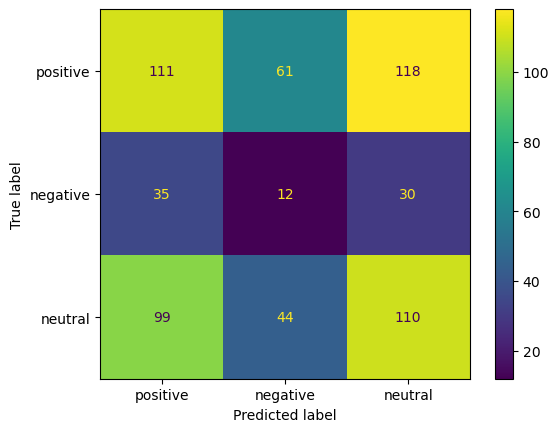

0.3758064516129032
              precision    recall  f1-score   support

    positive       0.10      0.16      0.12        77
    negative       0.43      0.43      0.43       253
     neutral       0.45      0.38      0.41       290

    accuracy                           0.38       620
   macro avg       0.33      0.32      0.32       620
weighted avg       0.40      0.38      0.39       620



In [47]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import matplotlib.pyplot as plt
data_senti['Studium_Label'] = data_senti['Studium_Label'].astype(str)
data_senti['Sentiment'] = data_senti['Sentiment'].astype(str)
confusion_mat = confusion_matrix(data_senti['Studium_Label'], data_senti['Sentiment'], labels=['positive', 'negative', 'neutral'])

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['positive', 'negative', 'neutral'])
disp.plot()
plt.show()
print(f1_score(data_senti['Studium_Label'], data_senti['Sentiment'], labels=['positive', 'negative', 'neutral'], average='micro'))
print(classification_report(
    data_senti['Studium_Label'],
    data_senti['Sentiment'],
    output_dict=False,
    target_names=['positive', 'negative', 'neutral']
))

In [48]:
total_sentiment = 0
neg = 0
pos = 0
neutr = 0

for i, text in enumerate(texts):
    doc = nlp(text)
    text_sentiment = 0
    word_count_all = 0
   # counter = 1
    
    for sentence in doc.sentences:
        word_count = len(sentence.words)
        word_count_all += word_count
        text_sentiment += (sentence.sentiment * word_count)

    

        #print(f"Wörter: {word_count}")
       
        #print(f"Senti: {sentence.sentiment}")
        
        #print(f"wordcount_all: {word_count_all}")
    
    total_sentiment = text_sentiment / word_count_all
    
    if total_sentiment <= 2.0 and total_sentiment >= 1.2:
        pos += 1
        sentiment= "positive"
    elif total_sentiment <= 1.3 and total_sentiment >= 0.9:
        neutr += 1
        sentiment= "neutral"
    else:
        neg += 1
        sentiment= "negative"
    #print(f"{i + 1} -> Overall Sentiment: {sentiment}")
    data_copy1.loc[i, 'Sentiment'] = sentiment
print(f"Neg: {neg} Pos: {pos} Neutr: {neutr}")



Neg: 42 Pos: 425 Neutr: 157


In [50]:
data_copy1.to_csv('subset_studium_with_sentiment2.csv', sep=';', index=False)

In [54]:
data_copy1_senti = pd.read_csv('subset_studium_with_sentiment2.csv', sep=';', nrows=700)
data_copy1_senti = data_copy1_senti[data_copy1_senti['Studium_Label'].notnull()]
data_copy1_senti = data_copy1_senti[data_copy1_senti['Sentiment'].notnull()]
data_copy1_senti.head()

,Unnamed: 0,Studium,Studium_Label,Studium_Comment,Sentiment
0,0.0,Die Vorlesungszeit war von Anfang September bi...,neutral,"pos:\nVielzahl an Kursen, praxisnäher, Sprachn...",positive
1,1.0,Die Pazmany Universität ist sehr klein im Verg...,positive,pos:\nsehr klein was ich schön und angenehm fa...,negative
2,2.0,Mit der Universität selbst hatten wir wenig zu...,neutral,neg:\nkaum Zeit zu arbeiten\n\npos: alles ist ...,positive
3,3.0,Da die Vorlesungen wegen der Pandemie online s...,positive,"pos:\nnette Mensa, großes Kursangebot, leichte...",positive
4,4.0,Die City University of Hong Kong hat eine groß...,negative,"neg: \nhoher Workload, Bewertung intransparent...",positive


In [55]:
print(calculateMatch(data_copy1_senti))

258


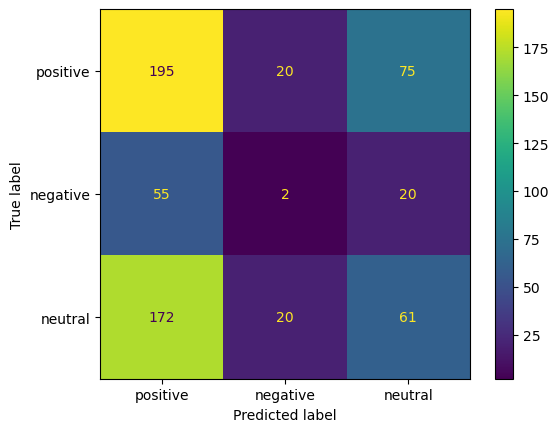

0.4161290322580646
              precision    recall  f1-score   support

    positive       0.05      0.03      0.03        77
    negative       0.39      0.24      0.30       253
     neutral       0.46      0.67      0.55       290

    accuracy                           0.42       620
   macro avg       0.30      0.31      0.29       620
weighted avg       0.38      0.42      0.38       620



In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, classification_report
import matplotlib.pyplot as plt
data_copy1_senti['Studium_Label'] = data_copy1_senti['Studium_Label'].astype(str)
data_copy1_senti['Sentiment'] = data_copy1_senti['Sentiment'].astype(str)
confusion_mat = confusion_matrix(data_copy1_senti['Studium_Label'], data_copy1_senti['Sentiment'], labels=['positive', 'negative', 'neutral'])

disp = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=['positive', 'negative', 'neutral'])
disp.plot()
plt.show()
print(f1_score(data_copy1_senti['Studium_Label'], data_copy1_senti['Sentiment'], labels=['positive', 'negative', 'neutral'], average='micro'))
print(classification_report(
    data_copy1_senti['Studium_Label'],
    data_copy1_senti['Sentiment'],
    output_dict=False,
    target_names=['positive', 'negative', 'neutral']
))